<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/DR-stage-identification/DatasetPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining necessary paths

In [10]:
# Define dataset paths
IMAGE_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Dataset"
CSV_PATH = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/dataset.csv"

# Define output directory for preprocessed images
OUTPUT_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Preprocessed_Dataset"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Preprocessing Functions

The functions below perform the following steps:
1. **crop_image_from_gray**: Center-crops the image by removing black borders.
2. **simple_resize**: Resizes the image to a fixed size of 256×256.
3. **preprocess_image**: Combines cropping, simple resizing, and Graham's preprocessing (subtract a Gaussian-blurred image and add a constant).


In [11]:
def crop_image_from_gray(img, tol=7):
    """
    Crop out black borders from the image.
    The image is assumed to be in BGR format.
    """
    if img.ndim == 2:  # Grayscale image
        mask = img > tol
        if mask.any():
            coords = np.argwhere(mask)
            x0, y0 = coords.min(axis=0)
            x1, y1 = coords.max(axis=0) + 1
            img = img[x0:x1, y0:y1]
        return img
    elif img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray > tol
        if mask.any():
            coords = np.argwhere(mask)
            x0, y0 = coords.min(axis=0)
            x1, y1 = coords.max(axis=0) + 1
            img = img[x0:x1, y0:y1]
        return img

def simple_resize(img, size=(256, 256)):
    """
    Resize the image to a fixed size using cv2.resize.
    This does not preserve the original aspect ratio.
    """
    return cv2.resize(img, size)

def preprocess_image(img, size=(256,256)):
    """
    Preprocess the image by:
      1. Cropping to remove black borders
      2. Resizing to a fixed size (256x256)
      3. Applying Graham's preprocessing: subtract a Gaussian-blurred version and add a constant
    """
    # Crop the image to remove black borders
    img_cropped = crop_image_from_gray(img)

    # Resize the image to 256x256 (ignoring original aspect ratio)
    img_resized = simple_resize(img_cropped, size=size)

    # Apply Graham's method: subtract a Gaussian-blurred image and add a constant
    sigma = size[0] / 30.0
    img_blur = cv2.GaussianBlur(img_resized, (0, 0), sigma)
    img_processed = cv2.addWeighted(img_resized, 4, img_blur, -4, 128)

    return img_processed

### Process Images Using the CSV File

The CSV file (which contains an `id_code` column) is used to iterate over the dataset. Each image file is assumed to be named `<id_code>.png` in the IMAGE_DIR. Each image is preprocessed and saved to the OUTPUT_DIR.

In [12]:
# Load the CSV file
df = pd.read_csv(CSV_PATH)
print("Loaded CSV with {} entries.".format(len(df)))

def process_and_save_image(id_code):
    filename = f"{id_code}.png"
    input_path = os.path.join(IMAGE_DIR, filename)
    img = cv2.imread(input_path)
    if img is None:
        print(f"Warning: Could not read {input_path}")
        return
    processed_img = preprocess_image(img, size=(256,256))
    output_path = os.path.join(OUTPUT_DIR, filename)
    cv2.imwrite(output_path, processed_img)

# Process each image listed in the CSV
for idx, row in tqdm(df.iterrows(), total=len(df)):
    process_and_save_image(row['id_code'])

print("Preprocessing complete. Preprocessed images are saved in:", OUTPUT_DIR)

Loaded CSV with 5041 entries.


100%|██████████| 5041/5041 [1:21:33<00:00,  1.03it/s]

Preprocessing complete. Preprocessed images are saved in: /content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Preprocessed_Dataset


### Visualising an example

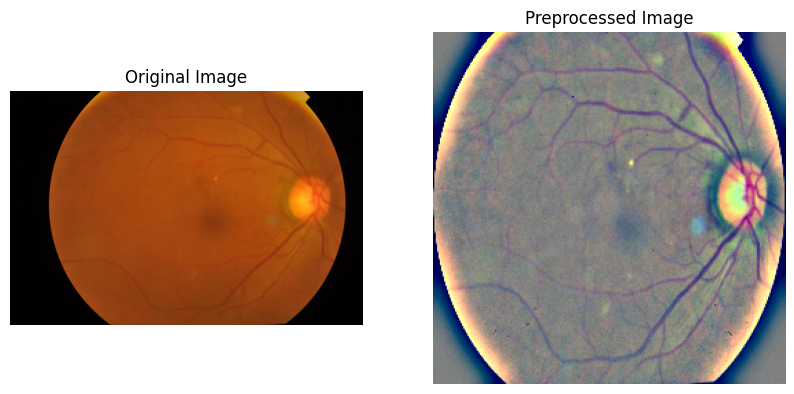

In [13]:
def display_images(original, processed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title("Preprocessed Image")
    plt.axis("off")
    plt.show()

# Use the first entry in the CSV as an example
example_id = df.iloc[0]['id_code']
example_filename = f"{example_id}.png"
example_path = os.path.join(IMAGE_DIR, example_filename)
original_img = cv2.imread(example_path)
if original_img is not None:
    processed_img = preprocess_image(original_img, size=(256,256))
    display_images(original_img, processed_img)
else:
    print("Could not load example image.")

### Spliting the Preprocessed Dataset into Train, Test, and Validation Sets

In [17]:
# Define destination directories for the split sets
TRAIN_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Train_Images"
TEST_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Test_Images"
VALIDATION_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Validation_Images"

# Define CSV paths for each split
TRAIN_CSV_PATH = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/train.csv"
TEST_CSV_PATH = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/test.csv"
VALIDATION_CSV_PATH = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/validation.csv"

# Create the directories if they don't exist
for directory in [TRAIN_DIR, TEST_DIR, VALIDATION_DIR]:
    os.makedirs(directory, exist_ok=True)

# Load the combined CSV (assumed to be created earlier and located at CSV_PATH)
df = pd.read_csv(CSV_PATH)

# Shuffle the dataset (using a fixed random state for reproducibility)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate split sizes using a 70:15:15 ratio
total_images = len(df_shuffled)
train_count = int(0.70 * total_images)
test_count = int(0.15 * total_images)
# The rest goes to validation
validation_count = total_images - train_count - test_count

# Create the splits
train_df = df_shuffled.iloc[:train_count]
test_df = df_shuffled.iloc[train_count:train_count + test_count]
validation_df = df_shuffled.iloc[train_count + test_count:]

print("Total images:", total_images)
print("Train images:", len(train_df))
print("Test images:", len(test_df))
print("Validation images:", len(validation_df))

# Directory where the preprocessed images are saved
PREPROCESSED_DIR = OUTPUT_DIR  # This is "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset/Preprocessed_Dataset"

# Function to copy images from the preprocessed folder to a target directory
def copy_images(df_subset, target_dir):
    for idx, row in df_subset.iterrows():
        filename = f"{row['id_code']}.png"
        src = os.path.join(PREPROCESSED_DIR, filename)
        dst = os.path.join(target_dir, filename)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            print("Image not found:", src)

# Copy images to their respective directories
copy_images(train_df, TRAIN_DIR)
copy_images(test_df, TEST_DIR)
copy_images(validation_df, VALIDATION_DIR)

# Save the CSV files for each split
train_df.to_csv(TRAIN_CSV_PATH, index=False)
test_df.to_csv(TEST_CSV_PATH, index=False)
validation_df.to_csv(VALIDATION_CSV_PATH, index=False)

print("Dataset splitting complete. Images copied and CSV files saved.")


Total images: 5041
Train images: 3528
Test images: 756
Validation images: 757
Dataset splitting complete. Images copied and CSV files saved.
